# Clasificación de Lesiones Cutáneas: Benchmark de Arquitecturas CNN

## Introducción al Proyecto

Este proyecto tiene como objetivo realizar un análisis comparativo (benchmark) del rendimiento de diversas arquitecturas de Redes Neuronales Convolucionales (CNN) en la tarea de clasificación automática de tipos de cáncer de piel y lesiones cutáneas. Evalaremos la capacidad de diferentes modelos, desde redes clásicas hasta arquitecturas modernas, para diferenciar correctamente entre distintas patologías.

## Descripción de los Datos

El conjunto de datos consiste exclusivamente en imágenes dermatoscópicas organizadas en una estructura de carpetas dentro del directorio `images/`, donde cada subcarpeta representa una categoría diagnóstica.

**Nota Importante:** Aunque existen metadatos tabulares asociados, este proyecto se centrará **únicamente en el análisis de las imágenes** como fuente de información para los modelos.

Las categorías a predecir, basadas en la estructura de carpetas, son las siguientes:

* **ACK**: Queratosis actínica (Actinic Keratosis)
* **BCC**: Carcinoma basocelular (Basal Cell Carcinoma)
* **BOD**: Enfermedad de Bowen (Bowen's disease)
* **MEL**: Melanoma
* **NEV**: Nevus (Lunar común)
* **SCC**: Carcinoma espinocelular (Squamous Cell Carcinoma)
* **SEK**: Queratosis seborreica (Seborrheic Keratosis)

## Modelos a Evaluar

Para obtener una visión completa, compararemos arquitecturas con diferentes enfoques de diseño:

1.  **ResNet (ej. ResNet50):** La referencia estándar de la industria gracias a sus conexiones residuales.
2.  **VGG (ej. VGG16):** Una arquitectura clásica y profunda, útil como línea base histórica.
3.  **EfficientNet (ej. B0/B1):** Modelos modernos que optimizan el equilibrio entre precisión y recursos computacionales.
4.  **MobileNet:** Arquitecturas ligeras diseñadas para dispositivos móviles, evaluando el compromiso entre velocidad y precisión.

1. Importación y Configuración Inicial

Primero importamos todo lo necesario y definimos las transformaciones. Como vamos a usar redes pre-entrenadas (ResNet, VGG, etc.), es obligatorio redimensionar las imágenes a 224x224 y usar la normalización estándar de ImageNet.

In [51]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuración básica
DATA_PATH = 'Datos/images'  # Tu carpeta raíz
BATCH_SIZE = 32       # Cuántas imágenes procesa la red de golpe
IMG_SIZE = 224        # Tamaño estándar para ResNet/VGG/EfficientNet

# Verificar si tenemos GPU (CUDA) o usaremos CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


2. Transformaciones y Carga del Dataset

Aquí definimos cómo preparar las imágenes. Convertimos los píxeles a tensores y los normalizamos para que la red matemática funcione mejor.

In [52]:
# Definir transformaciones estándar para modelos pre-entrenados
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Redimensionar a 224x224
    transforms.ToTensor(),                   # Convertir imagen a números (Tensor)
    transforms.Normalize(                    # Normalización estadística de ImageNet
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Cargar el dataset completo usando la estructura de carpetas
full_dataset = datasets.ImageFolder(root=DATA_PATH)

# Mostrar las clases encontradas automáticamente
class_names = full_dataset.classes
print(f"Clases detectadas: {class_names}")
print(f"Total de imágenes: {len(full_dataset)}")

Clases detectadas: ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']
Total de imágenes: 802


3. División Estratificada (Train / Val / Test)

La lógica es:

Sacamos las etiquetas (targets) de todas las imágenes.

Dividimos en Train (70%) y Resto (30%) usando estratificación.

Dividimos ese Resto por la mitad para obtener Val (15%) y Test (15%), también estratificado.

In [53]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from collections import Counter

# 1. Obtener las etiquetas de todo el dataset para poder estratificar
# full_dataset.targets es una lista con los índices de clase (0, 1, 2...) de cada foto
targets = full_dataset.targets
indices = list(range(len(full_dataset)))

# 2. Primer corte: Separar TRAIN (70%) del resto (Temp 30%)
# stratify=targets asegura que se mantengan las proporciones
train_idx, temp_idx = train_test_split(
    indices, 
    test_size=0.3, 
    stratify=targets, 
    random_state=42 # Semilla para que sea reproducible
)

# Ahora necesitamos las etiquetas de 'temp_idx' para el segundo corte
temp_targets = [targets[i] for i in temp_idx]

# 3. Segundo corte: Separar el Resto (30%) en VAL (15%) y TEST (15%)
# Al dividir el 30% restante a la mitad (0.5), obtenemos dos partes iguales del 15% total
val_idx, test_idx = train_test_split(
    temp_idx, 
    test_size=0.5, 
    stratify=temp_targets, 
    random_state=42
)

# 4. Crear los Subsets de PyTorch usando estos índices
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# 5. Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total: {len(full_dataset)}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Total: 802
Train: 561 | Val: 120 | Test: 121


4. Verificación de la Estratificación

Este paso es vital para tu reporte. Vamos a comprobar con un pequeño código que los porcentajes se han mantenido iguales en los tres grupos.

In [54]:
def get_class_distribution(dataset_obj, subset_indices):
    """Cuenta cuántas fotos hay de cada clase en un subset"""
    # Extraemos los targets solo de los índices seleccionados
    targets = [dataset_obj.targets[i] for i in subset_indices]
    count = Counter(targets)
    # Convertimos a porcentajes
    total = len(subset_indices)
    distribution = {class_names[k]: f"{(v/total)*100:.1f}%" for k, v in count.items()}
    return distribution

print("\n--- Distribución de Clases (Estratificación) ---")
print("Original:", get_class_distribution(full_dataset, indices))
print("Train:   ", get_class_distribution(full_dataset, train_idx))
print("Val:     ", get_class_distribution(full_dataset, val_idx))
print("Test:    ", get_class_distribution(full_dataset, test_idx))


--- Distribución de Clases (Estratificación) ---
Original: {'ACK': '18.7%', 'BCC': '18.7%', 'MEL': '6.5%', 'NEV': '18.7%', 'SCC': '18.7%', 'SEK': '18.7%'}
Train:    {'ACK': '18.7%', 'BCC': '18.7%', 'NEV': '18.7%', 'MEL': '6.4%', 'SEK': '18.7%', 'SCC': '18.7%'}
Val:      {'BCC': '19.2%', 'SEK': '19.2%', 'SCC': '18.3%', 'ACK': '18.3%', 'NEV': '18.3%', 'MEL': '6.7%'}
Test:     {'NEV': '19.0%', 'SCC': '19.0%', 'BCC': '18.2%', 'SEK': '18.2%', 'ACK': '19.0%', 'MEL': '6.6%'}


In [68]:
from torchvision import transforms

# 1. Transformaciones para ENTRENAMIENTO (Con "Trucos" / Augmentation)
# Aquí sí "alteramos" la realidad para que el modelo aprenda mejor
train_transforms = transforms.Compose([
    # --- AUMENTO DE DATOS (Solo aquí) ---
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom aleatorio
    transforms.RandomHorizontalFlip(p=0.5),              # Espejo
    transforms.RandomRotation(degrees=30),               # Rotación
    transforms.ColorJitter(brightness=0.1),              # Cambios ligeros de luz
    # ------------------------------------
    
    # --- FORMATO OBLIGATORIO (Para que entre en la ResNet) ---
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Transformaciones para VALIDACIÓN y TEST (Limpias)
# Aquí NO alteramos la imagen, solo la ajustamos al tamaño que pide la red
# 1. Corregir la transformación: Usar TUPLA (224, 224) para forzar cuadrado
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # <--- CAMBIO CLAVE: Doble paréntesis para forzar dimensiones
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [69]:
# Clase auxiliar para asignar transformaciones específicas a los Subsets
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index] # Obtener imagen y etiqueta original
        if self.transform:
            x = self.transform(x) # Aplicar la transformación que toque
        return x, y
        
    def __len__(self):
        return len(self.subset)

# APLICAMOS LAS TRANSFORMACIONES DIFERENCIADAS
# train_dataset -> Usa train_transforms (Con Data Augmentation)
train_dataset_final = TransformSubset(train_dataset, transform=train_transforms)

# val_dataset -> Usa val_test_transforms (LIMPIO)
val_dataset_final   = TransformSubset(val_dataset, transform=val_test_transforms)

# test_dataset -> Usa val_test_transforms (LIMPIO)
test_dataset_final  = TransformSubset(test_dataset, transform=val_test_transforms)

# Cargar en los DataLoaders
train_loader = DataLoader(train_dataset_final, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset_final, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset_final, batch_size=32, shuffle=False)

print("Datos listos: Train con Augmentation, Val/Test limpios.")

Datos listos: Train con Augmentation, Val/Test limpios.


# Estrategia de Entrenamiento 

Para garantizar un modelo robusto y evitar el sobreajuste (overfitting) en nuestro conjunto de datos de lesiones cutáneas, hemos implementado una estrategia de **Transfer Learning** profesional utilizando una arquitectura **ResNet50**.

## 1. Arquitectura y Configuración del Modelo
Utilizamos una **ResNet50** pre-entrenada en ImageNet.
* **Backbone (Cuerpo):** Congelamos inicialmente las capas convolucionales para preservar los extractores de características aprendidos (bordes, texturas).
* **Head (Cabeza):** Sustituimos la última capa por un bloque personalizado que incluye:
    * **Dropout (0.5):** Apaga aleatoriamente el 50% de las neuronas en cada paso para obligar a la red a aprender características redundantes y robustas.
    * **Linear Layer:** Capa densa con 7 salidas (una por tipo de lesión).
    * **Inicialización He (Kaiming):** Inicializamos los pesos de la nueva capa matemáticamente para optimizar la convergencia con funciones de activación ReLU.

## 2. Técnicas de Regularización y Optimización
Para mejorar la generalización, aplicamos:
* **AdamW (Weight Decay):** Un optimizador moderno que desacopla la caída de pesos (L2 Regularization) del gradiente, permitiendo una regularización más efectiva que el Adam estándar.
* **Data Augmentation:** En el set de entrenamiento aplicamos rotaciones, espejos y cambios de iluminación para que el modelo no memorice posiciones exactas.
* **Learning Rate Scheduler:** Utilizamos `ReduceLROnPlateau`. Si la métrica de validación se estanca durante 3 épocas, reducimos la velocidad de aprendizaje (Learning Rate) para intentar encontrar un mínimo más preciso en la función de pérdida.



In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torchvision import models
import matplotlib.pyplot as plt
import copy
import time

class SkinCancerTrainer:
    def __init__(self, num_classes, train_loader, val_loader, lr=1e-5, device=None):
        """
        Inicializa el entrenador con los datos y configuraciones.
        NOTA: El Learning Rate por defecto es bajo (1e-5) para Fine-Tuning.
        """
        self.num_classes = num_classes
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        
        # Detectar dispositivo automáticamente si no se provee
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Inicializando Trainer en: {self.device} (Modo FINE-TUNING)")
        
        # Construir el modelo y componentes
        self.model = self._build_model()
        self.criterion = nn.CrossEntropyLoss()
        
        # CAMBIO 1: Optimizamos TODOS los parámetros, no solo fc
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=3, factor=0.1
        )
        
        # Historial
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def _build_model(self):
        """Método privado para construir la ResNet50 modificada para Fine-Tuning"""
        print("Construyendo arquitectura ResNet50 y DESCONGELANDO pesos...")
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # CAMBIO 2: Descongelar capas base (Fine-Tuning real)
        # Permitimos que TODA la red aprenda.
        for param in model.parameters():
            param.requires_grad = True  # <--- CAMBIO CLAVE
            
        # CAMBIO 3: Modificar cabeza (Head) con capa intermedia
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),       # Capa intermedia (2048 -> 256)
            nn.BatchNorm1d(256),            # Estabiliza el aprendizaje
            nn.ReLU(),                      # Activación no lineal
            nn.Dropout(0.4),                # Evita memorizar (Dropout un poco más bajo)
            nn.Linear(256, self.num_classes) # Capa final (256 -> 7)
        )
        
        # Inicialización He (Kaiming) para la nueva cabeza
        for m in model.fc.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
                    
        return model.to(self.device)

    def _train_epoch(self):
        """Ejecuta una época de entrenamiento"""
        self.model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            
            outputs = self.model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = running_corrects.double() / len(self.train_loader.dataset)
        return epoch_loss, epoch_acc.item()

    def _validate_epoch(self):
        """Ejecuta una época de validación"""
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
        epoch_loss = running_loss / len(self.val_loader.dataset)
        epoch_acc = running_corrects.double() / len(self.val_loader.dataset)
        return epoch_loss, epoch_acc.item()

    def fit(self, epochs=15):
        """Bucle principal de entrenamiento"""
        since = time.time()
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        print(f"Inicio del entrenamiento (Fine-Tuning): {epochs} épocas")
        print("-" * 30)
        
        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}')
            
            # Entrenar
            train_loss, train_acc = self._train_epoch()
            # Validar
            val_loss, val_acc = self._validate_epoch()
            
            # Guardar en historial
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            
            # Step del Scheduler
            self.scheduler.step(val_loss)
            
            # Checkpoint del mejor modelo
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(self.model.state_dict())
                print("-> ¡Nuevo mejor modelo encontrado!")
            
            print()

        time_elapsed = time.time() - since
        print(f'Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Mejor Accuracy Val: {best_acc:.4f}')
        
        # Cargar los mejores pesos en el modelo actual
        self.model.load_state_dict(best_model_wts)

    def save_model(self, path="best_model.pth"):
        """Guarda el modelo en disco"""
        torch.save(self.model.state_dict(), path)
        print(f"Modelo guardado en: {path}")

    def plot_history(self):
        """Genera las gráficas de entrenamiento"""
        epochs = range(1, len(self.history['train_acc']) + 1)
        
        plt.figure(figsize=(12, 5))
        
        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_acc'], 'bo-', label='Train Acc')
        plt.plot(epochs, self.history['val_acc'], 'ro-', label='Val Acc')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)
        
        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_loss'], 'bo-', label='Train Loss')
        plt.plot(epochs, self.history['val_loss'], 'ro-', label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.show()

Inicializando Trainer en: cuda (Modo FINE-TUNING)
Construyendo arquitectura ResNet50 y DESCONGELANDO pesos...
Inicio del entrenamiento (Fine-Tuning): 15 épocas
------------------------------
Epoch 1/15
Train Loss: 7.3298 Acc: 0.2549
Val Loss: 19.1159 Acc: 0.2750
-> ¡Nuevo mejor modelo encontrado!

Epoch 2/15
Train Loss: 4.4876 Acc: 0.2496
Val Loss: 10.4295 Acc: 0.2750

Epoch 3/15
Train Loss: 3.3321 Acc: 0.2068
Val Loss: 240.2734 Acc: 0.2333

Epoch 4/15
Train Loss: 4.1246 Acc: 0.1996
Val Loss: 21.8875 Acc: 0.2250

Epoch 5/15
Train Loss: 4.6570 Acc: 0.1800
Val Loss: 365.7381 Acc: 0.2083

Epoch 6/15
Train Loss: 3.4159 Acc: 0.1783
Val Loss: 10.3116 Acc: 0.1833

Epoch 7/15
Train Loss: 3.7969 Acc: 0.2282
Val Loss: 5.0433 Acc: 0.2167

Epoch 8/15
Train Loss: 3.2876 Acc: 0.1854
Val Loss: 11.7708 Acc: 0.2167

Epoch 9/15
Train Loss: 3.4103 Acc: 0.1604
Val Loss: 3.2608 Acc: 0.2250

Epoch 10/15
Train Loss: 3.0299 Acc: 0.1836
Val Loss: 11.6981 Acc: 0.1917

Epoch 11/15
Train Loss: 3.1731 Acc: 0.1693


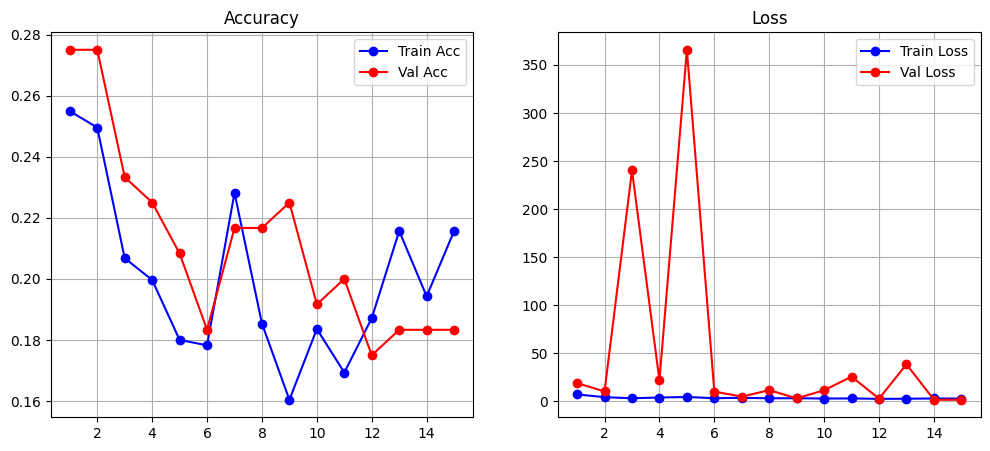

Modelo guardado en: resnet50_skin_cancer_oop.pth


In [58]:
# 1. Instanciar el Entrenador (Trainer)
# Asumimos que train_loader, val_loader y class_names ya existen de tus celdas anteriores
trainer = SkinCancerTrainer(
    num_classes=len(class_names), # Tus 7 clases
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-3
)

# 2. Entrenar
trainer.fit(epochs=15)

# 3. Visualizar gráficas
trainer.plot_history()

# 4. Guardar resultado
trainer.save_model("resnet50_skin_cancer_oop.pth")

# Modelo con warm + transfer learning

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torchvision import models
import matplotlib.pyplot as plt
import copy
import time

class SkinCancerTrainer:
    def __init__(self, num_classes, train_loader, val_loader, lr=1e-3, device=None):
        self.num_classes = num_classes
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        
        # Detectar dispositivo
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Inicializando Trainer en: {self.device}")
        
        # Construcción del modelo
        self.model = self._build_model()
        
        # DEFINICIÓN DE PÉRDIDA Y OPTIMIZADOR
        self.criterion = nn.CrossEntropyLoss()
        
        # FASE 1: El optimizador solo ve la CABEZA (fc) al principio
        # weight_decay ayuda a regularizar
        self.optimizer = optim.AdamW(self.model.fc.parameters(), lr=self.lr, weight_decay=1e-3)
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=2, factor=0.1
        )
        
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def _build_model(self):
        print("Construyendo ResNet50 (Congelada inicialmente para Warm-Up)...")
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # 1. CONGELAR TODO (BACKBONE)
        # Esto es vital para la FASE 1
        for param in model.parameters():
            param.requires_grad = False
            
        # 2. NUEVA CABEZA (HEAD)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),       
            nn.BatchNorm1d(512),            
            nn.ReLU(),
            nn.Dropout(0.5),                
            nn.Linear(512, self.num_classes)
        )
        
        # Inicialización He
        for m in model.fc.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: init.constant_(m.bias, 0)
                    
        return model.to(self.device)

    # --- ESTE ES EL MÉTODO QUE TE FALTABA ---
    def unfreeze_backend(self, lr=1e-5):
        """Descongela la ResNet para la Fase 2 (Fine Tuning)"""
        print(f"\n>>> DESCONGELANDO MODELO COMPLETO (LR={lr}) <<<")
        
        # 1. Descongelar pesos
        for param in self.model.parameters():
            param.requires_grad = True
            
        # 2. Actualizar optimizador para que vea TODA la red
        # Usamos un LR bajo para no romper lo aprendido
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)

    def _train_epoch(self):
        self.model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            
            outputs = self.model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            
            # Gradient Clipping (Evita el error de Loss gigante)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        return running_loss / len(self.train_loader.dataset), running_corrects.double() / len(self.train_loader.dataset)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
        return running_loss / len(self.val_loader.dataset), running_corrects.double() / len(self.val_loader.dataset)

    def fit(self, epochs):
        best_acc = 0.0
        print(f"Iniciando ciclo de {epochs} épocas...")
        
        for epoch in range(epochs):
            train_loss, train_acc = self._train_epoch()
            val_loss, val_acc = self._validate_epoch()
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc.item())
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc.item())
            
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            
            self.scheduler.step(val_loss)
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), "best_model.pth")
    
    def plot_history(self):
        epochs = range(1, len(self.history['train_acc']) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(epochs, self.history['train_acc'], label='Train'); plt.plot(epochs, self.history['val_acc'], label='Val'); plt.title('Accuracy'); plt.legend()
        plt.subplot(1, 2, 2); plt.plot(epochs, self.history['train_loss'], label='Train'); plt.plot(epochs, self.history['val_loss'], label='Val'); plt.title('Loss'); plt.legend()
        plt.show()

Inicializando Trainer en: cuda
Construyendo ResNet50 (Congelada inicialmente para Warm-Up)...

--- FASE 1: WARM UP (Solo Cabeza) ---
Iniciando ciclo de 5 épocas...
Epoch 1/5 | Train Loss: 14.1134 Acc: 0.2193 | Val Loss: 4.9167 Acc: 0.3667
Epoch 2/5 | Train Loss: 9.1343 Acc: 0.3886 | Val Loss: 5.8197 Acc: 0.3917
Epoch 3/5 | Train Loss: 8.5072 Acc: 0.4563 | Val Loss: 5.7711 Acc: 0.3917
Epoch 4/5 | Train Loss: 7.4173 Acc: 0.4563 | Val Loss: 5.3234 Acc: 0.4333
Epoch 5/5 | Train Loss: 6.6252 Acc: 0.4991 | Val Loss: 5.5094 Acc: 0.3917

>>> DESCONGELANDO MODELO COMPLETO (LR=1e-05) <<<

--- FASE 2: FINE TUNING (Modelo Completo) ---
Iniciando ciclo de 10 épocas...
Epoch 1/10 | Train Loss: 6.5045 Acc: 0.5169 | Val Loss: 5.5953 Acc: 0.4083
Epoch 2/10 | Train Loss: 5.7647 Acc: 0.5472 | Val Loss: 5.5000 Acc: 0.4250
Epoch 3/10 | Train Loss: 6.0190 Acc: 0.4813 | Val Loss: 5.4230 Acc: 0.4167
Epoch 4/10 | Train Loss: 6.1400 Acc: 0.5187 | Val Loss: 5.3108 Acc: 0.4417
Epoch 5/10 | Train Loss: 6.1664 Acc:

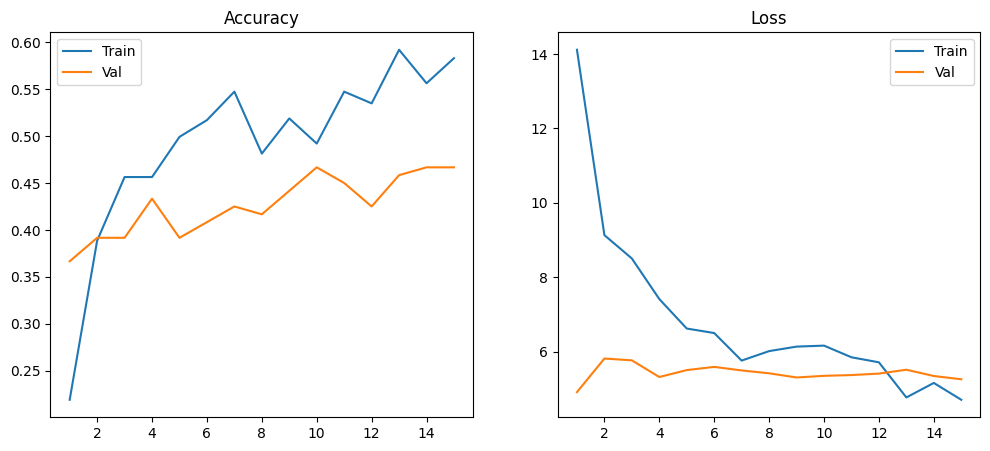

In [65]:
# 1. Instanciar (Reiniciamos para asegurar que empieza congelado)
trainer = SkinCancerTrainer(
    num_classes=len(class_names),
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-3
)

# 2. FASE 1: Warm Up (Cabeza)
# Entrenamos solo las capas finales para estabilizar
print("\n--- FASE 1: WARM UP (Solo Cabeza) ---")
trainer.fit(epochs=5)

# 3. FASE 2: Fine Tuning (Completo)
# Descongelamos y refinamos con LR bajo
trainer.unfreeze_backend(lr=1e-5) 
print("\n--- FASE 2: FINE TUNING (Modelo Completo) ---")
trainer.fit(epochs=10) # Puedes subir a 15 si ves que sigue mejorando

# 4. Ver resultados
trainer.plot_history()

In [67]:
# 1. Corregir la transformación: Usar TUPLA (224, 224) para forzar cuadrado
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # <--- CAMBIO CLAVE: Doble paréntesis para forzar dimensiones
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Re-aplicar al Test Set (usando tu clase TransformSubset)
# Asegúrate de que 'test_dataset' (los índices crudos) sigue en memoria
test_dataset_final = TransformSubset(test_dataset, transform=val_test_transforms)

# 3. Re-crear el DataLoader
test_loader = DataLoader(test_dataset_final, batch_size=32, shuffle=False)

print("DataLoader de Test regenerado con tamaño forzado a 224x224.")

# 4. Ahora sí, evalúa
preds, labels = evaluar_test(trainer.model, test_loader)

DataLoader de Test regenerado con tamaño forzado a 224x224.
Presición final en TEST SET: 37.19%


# Resnet 18 (menos param    )

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torchvision import models
import matplotlib.pyplot as plt
import copy
import time

class SkinCancerTrainer:
    def __init__(self, num_classes, train_loader, val_loader, lr=1e-3, device=None):
        self.num_classes = num_classes
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        
        # Detectar dispositivo
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Inicializando Trainer (ResNet18) en: {self.device}")
        
        # Construcción del modelo
        self.model = self._build_model()
        
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizador inicial (Solo ve la cabeza)
        self.optimizer = optim.AdamW(self.model.fc.parameters(), lr=self.lr, weight_decay=1e-3)
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=2, factor=0.1
        )
        
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def _build_model(self):
        print("Cargando ResNet18 (Congelada)...")
        # CAMBIO 1: Cargamos ResNet18 en lugar de ResNet50
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # 1. CONGELAR TODO
        for param in model.parameters():
            param.requires_grad = False
            
        # 2. NUEVA CABEZA
        # CAMBIO 2: ResNet18 entrega 512 características (ResNet50 entregaba 2048)
        num_ftrs = model.fc.in_features # Esto será 512
        
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),       # Bajamos a 256 (suficiente para ResNet18)
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),                # Mantenemos Dropout alto por tener pocos datos
            nn.Linear(256, self.num_classes)
        )
        
        # Inicialización He
        for m in model.fc.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: init.constant_(m.bias, 0)
                    
        return model.to(self.device)

    def unfreeze_backend(self, lr=1e-5):
        """Descongela para Fase 2"""
        print(f"\n>>> DESCONGELANDO RESNET18 COMPLETA (LR={lr}) <<<")
        for param in self.model.parameters():
            param.requires_grad = True
        
        # Actualizamos optimizador para toda la red
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)

    def _train_epoch(self):
        self.model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = self.criterion(outputs, labels)
            loss.backward()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        return running_loss / len(self.train_loader.dataset), running_corrects.double() / len(self.train_loader.dataset)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        return running_loss / len(self.val_loader.dataset), running_corrects.double() / len(self.val_loader.dataset)

    def fit(self, epochs):
        best_acc = 0.0
        print(f"Iniciando ciclo de {epochs} épocas...")
        for epoch in range(epochs):
            t_loss, t_acc = self._train_epoch()
            v_loss, v_acc = self._validate_epoch()
            
            self.history['train_loss'].append(t_loss)
            self.history['train_acc'].append(t_acc.item())
            self.history['val_loss'].append(v_loss)
            self.history['val_acc'].append(v_acc.item())
            
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {t_loss:.4f} Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f} Acc: {v_acc:.4f}')
            
            self.scheduler.step(v_loss)
            
            if v_acc > best_acc:
                best_acc = v_acc
                torch.save(self.model.state_dict(), "best_resnet18.pth")
    
    def plot_history(self):
        epochs = range(1, len(self.history['train_acc']) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(epochs, self.history['train_acc'], label='Train'); plt.plot(epochs, self.history['val_acc'], label='Val'); plt.title('Accuracy'); plt.legend()
        plt.subplot(1, 2, 2); plt.plot(epochs, self.history['train_loss'], label='Train'); plt.plot(epochs, self.history['val_loss'], label='Val'); plt.title('Loss'); plt.legend()
        plt.show()

Inicializando Trainer (ResNet18) en: cuda
Cargando ResNet18 (Congelada)...
--- FASE 1 ---
Iniciando ciclo de 5 épocas...
Epoch 1/5 | Train Loss: 12.3124 Acc: 0.1569 | Val Loss: 9.4764 Acc: 0.1833
Epoch 2/5 | Train Loss: 8.7110 Acc: 0.2799 | Val Loss: 6.2041 Acc: 0.3167
Epoch 3/5 | Train Loss: 7.1366 Acc: 0.3476 | Val Loss: 5.0808 Acc: 0.3250
Epoch 4/5 | Train Loss: 6.3078 Acc: 0.3565 | Val Loss: 4.6247 Acc: 0.3750
Epoch 5/5 | Train Loss: 5.2412 Acc: 0.4349 | Val Loss: 4.4986 Acc: 0.3917

>>> DESCONGELANDO RESNET18 COMPLETA (LR=1e-05) <<<
--- FASE 2 ---
Iniciando ciclo de 15 épocas...
Epoch 1/15 | Train Loss: 4.9830 Acc: 0.4225 | Val Loss: 4.3462 Acc: 0.4333
Epoch 2/15 | Train Loss: 5.2488 Acc: 0.4581 | Val Loss: 4.2711 Acc: 0.4417
Epoch 3/15 | Train Loss: 5.1166 Acc: 0.4385 | Val Loss: 4.1751 Acc: 0.4417
Epoch 4/15 | Train Loss: 4.6177 Acc: 0.4759 | Val Loss: 4.0802 Acc: 0.4667
Epoch 5/15 | Train Loss: 4.4513 Acc: 0.4742 | Val Loss: 4.0330 Acc: 0.4333
Epoch 6/15 | Train Loss: 4.7140 Ac

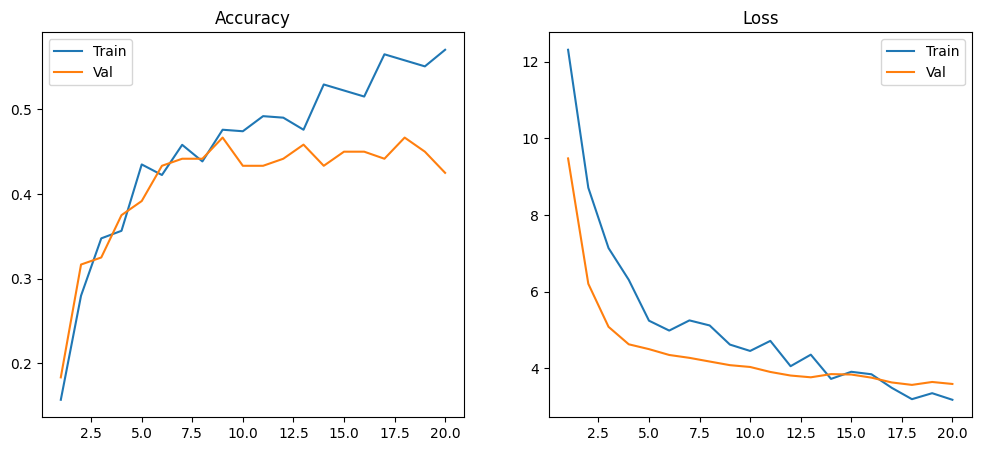

In [74]:
# 1. Instanciar
trainer = SkinCancerTrainer(
    num_classes=len(class_names),
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-3
)

# 2. Fase Warm-Up (5 épocas)
print("--- FASE 1 ---")
trainer.fit(epochs=5)

# 3. Fase Fine-Tuning (10-15 épocas)
trainer.unfreeze_backend(lr=1e-5)
print("--- FASE 2 ---")
trainer.fit(epochs=15) # Le damos un poco más de tiempo porque la red es más ligera

trainer.plot_history()